In [1]:
# Add the path of the beer source code ot the PYTHONPATH.
from collections import defaultdict
import random
import sys
sys.path.insert(0, '../')
from beer import __init__

import copy

import beer
import numpy as np
import torch

# For plotting.
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

# Convenience functions for plotting.
import plotting

Loading BokehJS ...

### Set GPU

In [2]:
torch.cuda.set_device("cuda:3")
torch.cuda.current_device()
# device = torch.device("cuda:5")
# xxx.to(device)

3

### Synthetic Data

In [3]:
import synthetic_data
data, trans_mat = synthetic_data.generate_sequential_data()

### Construct Graph
This graph describe the transformation of hidden state.

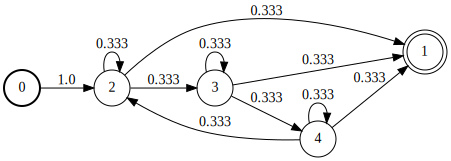

In [4]:
graph = beer.graph.Graph()

# Initial and final state are non-emitting.
s0 = graph.add_state()
s4 = graph.add_state()
graph.start_state = s0
graph.end_state = s4

s1 = graph.add_state(pdf_id=0)
s2 = graph.add_state(pdf_id=1)
s3 = graph.add_state(pdf_id=2)
graph.add_arc(s0, s1)
graph.add_arc(s1, s1)
graph.add_arc(s1, s2)
graph.add_arc(s2, s2)
graph.add_arc(s2, s3)
graph.add_arc(s3, s3)
graph.add_arc(s3, s1)
graph.add_arc(s1, s4)
graph.add_arc(s2, s4)
graph.add_arc(s3, s4)

graph.normalize()
graph

In [5]:
cgraph = graph.compile()
cgraph.final_log_probs

tensor([-1.0986, -1.0986, -1.0986])

### Pretrain HMM 

In [6]:
# We use the global mean/cov. matrix of the data to initialize the mixture.
data_mean = torch.from_numpy(data.mean(axis=0)).float()
data_var = torch.from_numpy(np.cov(data.T)).float()

init_states = torch.LongTensor([0])
final_states = torch.LongTensor([2])
transitions = torch.from_numpy(trans_mat).float()

# HMM (full cov).
modelset = beer.NormalSet.create(data_mean, data_var, size=len(transitions),
                                prior_strength=1., noise_std=0, 
                                cov_type='full')
hmm_full = beer.HMM.create(cgraph, modelset).double().cuda()

hmm_full

HMM(
  (modelset): DynamicallyOrderedModelSet(
    (original_modelset): NormalSet(
      (means_precisions): ConjugateBayesianParameter(prior=NormalWishart, posterior=NormalWishart)
    )
  )
  (graph): <CompiledGraph>
)

In [7]:
epochs = 30
lrate = 1.
X = torch.from_numpy(data).cuda()

optim = beer.VBConjugateOptimizer(hmm_full.mean_field_factorization(), lrate)

elbos = []

for epoch in range(epochs):
    optim.init_step()
    elbo = beer.evidence_lower_bound(hmm_full, X, datasize=len(X), viterbi=False)
    elbo.backward()
    elbos.append(float(elbo) / len(X)) 
    optim.step()

In [8]:
fig = figure()
fig.line(range(len(elbos)), elbos)
show(fig)

### Train VAE

In [9]:
encoder = beer.nnet.ResidualFeedForwardNet(dim_in=2, nblocks=2, block_width=2)
decoder = beer.nnet.ResidualFeedForwardNet(dim_in=2, nblocks=2, block_width=2)
vae = beer.VAE(hmm_full, encoder, decoder).double().cuda()

In [10]:
# small number of epochs for testing
epochs = 800
update_prior_after_epoch = 50
prior_lrate = 1.
cjg_optim = beer.VBConjugateOptimizer(vae.mean_field_factorization(), lrate=0)
std_optim = torch.optim.Adam(vae.parameters(), lr=1e-3)
optim = beer.VBOptimizer(cjg_optim, std_optim)

In [11]:
elbos = []
for e in range(epochs):
    optim.init_step()
    elbo = beer.evidence_lower_bound(vae, X, nsamples=5)
    elbo.backward()
    optim.step()
    
    if e >= update_prior_after_epoch:
        cjg_optim.lrate = prior_lrate
    elbos.append(float(elbo) / len(X))

In [12]:
fig = figure()
fig.line(range(len(elbos[100:])), elbos[100:])
show(fig)
elbos[-1]

-24771.77312146977

### Save Model

In [13]:
torch.save(vae.state_dict(), 'hmm-vae-cuda.pkl')

### Load Model

In [14]:
vae.load_state_dict(torch.load('hmm-vae-cuda.pkl'))

<All keys matched successfully>